### Câu hỏi 4: Trong và trước các trận mưa lịch sử tháng 10–11/2025 vừa rồi ở Huế, những biến khí tượng nào thể hiện sự thay đổi rõ rệt nhất, có gì khác biệt so với các trận còn lại không?

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import timedelta

# Đọc dữ liệu
file_path = Path("../data/processed/weather_processed.csv").resolve()
df = pd.read_csv(file_path)

# Chuẩn hóa
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.sort_values(['latitude', 'longitude', 'datetime']).reset_index(drop=True)

print("Tổng số dòng:", len(df))
df.head()


Tổng số dòng: 300937


,latitude,longitude,datetime,temperature (C degree),humidity (%),precipitation (mm),windspeed (km/h),winddirection (degrees),pressure (hPa),dewpoint (C degree),month,hour,season,day_night,location_id
0,16.38,107.62,2021-01-01 00:00:00,15.6,98.0,NaN,3.6,320.0,1022.0,15.3,1,0,Dry,Night,1
1,16.38,107.62,2021-01-01 01:00:00,16.0,100.0,NaN,13.0,260.0,1023.0,16.0,1,1,Dry,Night,1
2,16.38,107.62,2021-01-01 02:00:00,17.0,94.0,NaN,9.4,250.0,1024.0,16.0,1,2,Dry,Night,1
3,16.38,107.62,2021-01-01 03:00:00,16.6,96.0,NaN,7.2,340.0,1023.5,16.0,1,3,Dry,Night,1
4,16.38,107.62,2021-01-01 04:00:00,17.0,94.0,NaN,7.6,260.0,1024.0,16.0,1,4,Dry,Night,1


In [36]:
# Phát hiện và tổng hợp các đợt mưa
def detect_rain_events(group, max_gap_hours=1):
    # Đảm bảo chuỗi thời gian liên tục và đúng thứ tự
    group = group.sort_values('datetime').reset_index(drop=True)

    # Xác định thời điểm có mưa chuyển lượng mưa thành biến nhị phân: có mưa / không mưa
    group['is_rain'] = group['precipitation (mm)'] > 0

    event_id = 0          # ID đợt mưa
    gap = 0               # số giờ không mưa liên tiếp
    event_ids = []        # event_id cho từng thời điểm

    # Duyệt qua chuỗi thời gian để gán nhãn đợt mưa
    for r in group['is_rain']:
        if r:
            # Nếu đang có mưa
            if gap > max_gap_hours:
                # Nếu trước đó có khoảng khô dài hơn ngưỡng cho phép -> bắt đầu một đợt mưa mới
                event_id += 1

            # Reset khoảng khô vì mưa đã xảy ra
            gap = 0
            event_ids.append(event_id)

        else:
            # Nếu không mưa
            gap += 1
            # Không gán event_id
            event_ids.append(None)

    # Gán nhãn đợt mưa vào DataFrame
    group['event_id'] = event_ids

    # Chỉ giữ lại các thời điểm thuộc đợt mưa
    rain_only = group[group['event_id'].notna()]

    if rain_only.empty:
        return pd.DataFrame()

    return (
        rain_only
        .groupby('event_id')
        .agg(
            latitude=('latitude', 'first'),
            longitude=('longitude', 'first'),
            start_time=('datetime', 'min'),
            end_time=('datetime', 'max'),
            duration_hours=('datetime', 'count'),
            total_precipitation=('precipitation (mm)', 'sum')
        )
        .reset_index(drop=True)
    )


In [37]:
# Lọc ra các trận mưa lớn
events = []

for (lat, lon), g in df.groupby(['latitude', 'longitude']):
    e = detect_rain_events(g)
    if not e.empty:
        events.append(e)

events_df = pd.concat(events, ignore_index=True)

# Chỉ giữ mưa lớn >=200 mm
events_df = events_df[events_df['total_precipitation'] >= 200]

events_df = events_df.sort_values('start_time').reset_index(drop=True)

print("Số trận mưa lớn:", len(events_df))
events_df


Số trận mưa lớn: 84


,latitude,longitude,start_time,end_time,duration_hours,total_precipitation
0,16.38,107.62,2021-09-09 23:00:00,2021-09-13 20:00:00,94,277.9
1,16.52,107.59,2021-09-09 23:00:00,2021-09-13 20:00:00,94,277.9
2,16.44,107.65,2021-09-09 23:00:00,2021-09-13 20:00:00,94,277.9
3,16.53,107.67,2021-09-09 23:00:00,2021-09-13 20:00:00,94,277.9
4,16.47,107.62,2021-09-09 23:00:00,2021-09-13 20:00:00,94,277.9
...,...,...,...,...,...,...
79,16.52,107.59,2025-11-14 17:00:00,2025-11-21 04:00:00,155,224.4
80,16.43,107.58,2025-11-14 17:00:00,2025-11-21 04:00:00,155,224.4
81,16.47,107.62,2025-11-14 17:00:00,2025-11-21 04:00:00,155,224.4
82,16.53,107.67,2025-11-14 17:00:00,2025-11-21 04:00:00,155,224.4


In [38]:
# Lọc ra các đợt mưa lớn trong tháng 10, 11 năm 2025
target_events = events_df[
    (events_df['start_time'].dt.year == 2025) &
    (events_df['start_time'].dt.month.isin([10, 11]))
].reset_index(drop=True)

merged_events = (
    target_events
    .groupby(['start_time', 'end_time'], as_index=False)
    .agg(
        latitude=('latitude', 'first'),
        longitude=('longitude', 'first'),
        duration_hours=('duration_hours', 'first'),
        total_precipitation=('total_precipitation', 'first')
    )
    .sort_values('start_time')
    .reset_index(drop=True)
)

target_events = merged_events

print("Số đợt mưa lớn tháng 10–11/2025:", len(target_events))
target_events


Số đợt mưa lớn tháng 10–11/2025: 3


,start_time,end_time,latitude,longitude,duration_hours,total_precipitation
0,2025-10-20 04:00:00,2025-10-24 08:00:00,16.43,107.58,97,211.1
1,2025-10-24 20:00:00,2025-10-30 00:00:00,16.38,107.62,123,288.2
2,2025-11-14 17:00:00,2025-11-21 04:00:00,16.38,107.62,155,224.4


In [39]:
# Lấy dữ liệu 24 giờ trước mỗi đợt mưa lớn
pre_rain_list = []

for idx, event in target_events.iterrows():
    start_time = event['start_time']
    lat = event['latitude']
    lon = event['longitude']
    
    mask = (
        (df['latitude'] == lat) &
        (df['longitude'] == lon) &
        (df['datetime'] >= start_time - timedelta(hours=24)) &
        (df['datetime'] <= start_time + timedelta(hours=5))
    )
    
    temp_df = df.loc[mask].copy()
    
    # giờ trước mưa
    temp_df['hours_before_rain'] = (
        temp_df['datetime'] - start_time
    ).dt.total_seconds() / 3600
    
    # gắn ID đợt mưa để phân biệt
    temp_df['event_id'] = idx
    temp_df['event_start'] = start_time
    
    pre_rain_list.append(temp_df)

# gộp tất cả đợt mưa
pre_df = pd.concat(pre_rain_list, ignore_index=True)

print("Dữ liệu 24h trước mưa:", len(pre_df))
pre_df.head()


Dữ liệu 24h trước mưa: 89


,latitude,longitude,datetime,temperature (C degree),humidity (%),precipitation (mm),windspeed (km/h),winddirection (degrees),pressure (hPa),dewpoint (C degree),month,hour,season,day_night,location_id,hours_before_rain,event_id,event_start
0,16.43,107.58,2025-10-19 04:00:00,28.0,84.0,0.2,4.0,330.0,1011.0,25.0,10,4,Rainy,Night,2,-24.0,0,2025-10-20 04:00:00
1,16.43,107.58,2025-10-19 05:00:00,29.0,75.0,0.0,4.0,20.0,1011.0,24.1,10,5,Rainy,Night,2,-23.0,0,2025-10-20 04:00:00
2,16.43,107.58,2025-10-19 06:00:00,29.0,75.0,0.1,4.0,330.0,1010.0,24.1,10,6,Rainy,Day,2,-22.0,0,2025-10-20 04:00:00
3,16.43,107.58,2025-10-19 07:00:00,29.0,75.0,0.6,6.0,10.0,1009.0,24.1,10,7,Rainy,Day,2,-21.0,0,2025-10-20 04:00:00
4,16.43,107.58,2025-10-19 08:00:00,28.0,79.0,0.2,7.0,10.0,1008.0,24.0,10,8,Rainy,Day,2,-20.0,0,2025-10-20 04:00:00


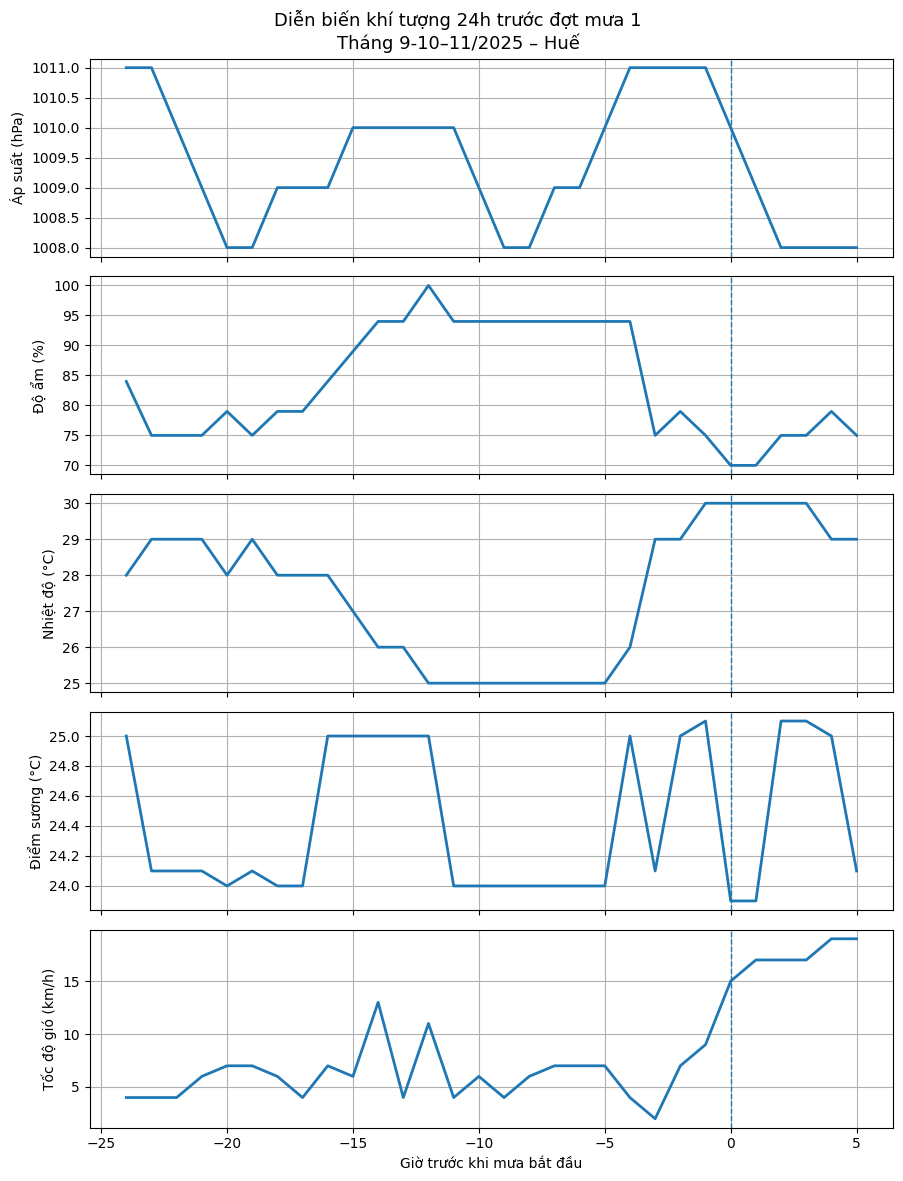

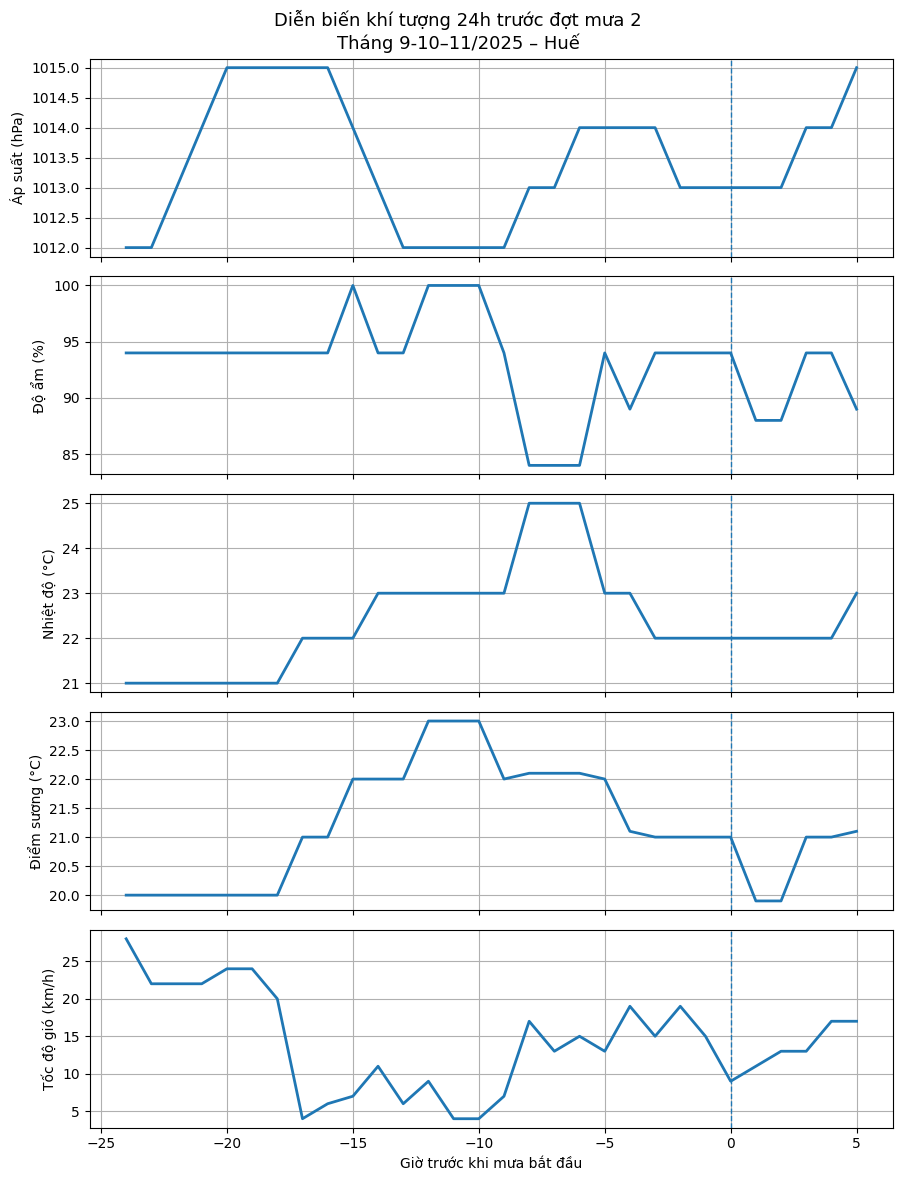

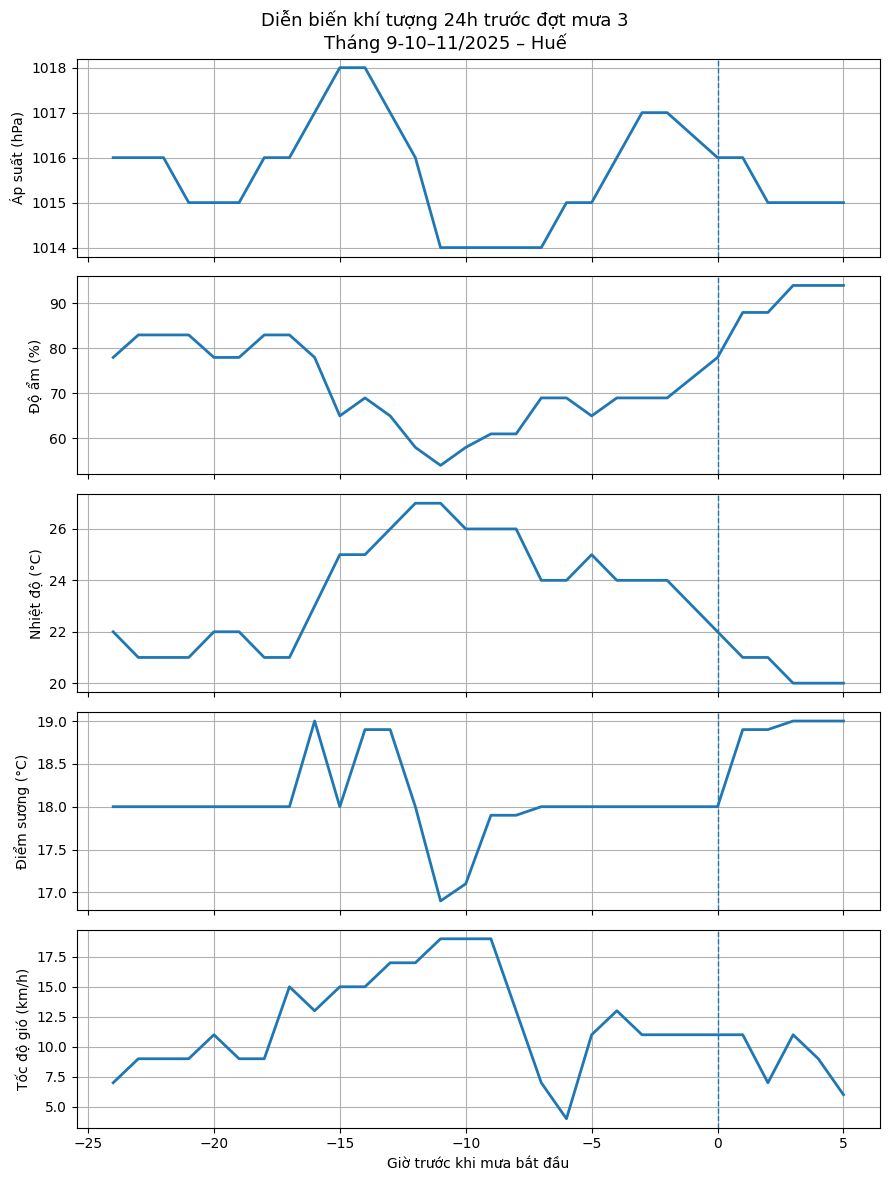

In [ ]:
# Vẽ biểu đồ diễn biến khí tượng 24h trước mỗi đợt mưa lớn
variables = {
    'pressure (hPa)': 'Áp suất (hPa)',
    'humidity (%)': 'Độ ẩm (%)',
    'temperature (C degree)': 'Nhiệt độ (°C)',
    'dewpoint (C degree)': 'Điểm sương (°C)',
    'windspeed (km/h)': 'Tốc độ gió (km/h)'
}

event_ids = sorted(pre_df['event_id'].unique())

for eid in event_ids:
    temp = pre_df[pre_df['event_id'] == eid].sort_values('hours_before_rain')

    fig, axes = plt.subplots(len(variables), 1, figsize=(9, 12), sharex=True)

    for ax, (col, label) in zip(axes, variables.items()):
        ax.plot(
            temp['hours_before_rain'],
            temp[col],
            linewidth=2
        )
        ax.axvline(0, linestyle='--', linewidth=1)
        ax.set_ylabel(label)
        ax.grid(True)

    axes[-1].set_xlabel("Giờ trước khi mưa bắt đầu")

    fig.suptitle(
        f"Diễn biến khí tượng 24h trước đợt mưa {eid+1}\n"
        f"Tháng 10–11/2025 – Huế",
        fontsize=13
    )

    plt.tight_layout()
    plt.show()


### NHẬN XÉT
#### 1. Nhận xét tổng quan
Trong cả 3 đợt, diễn biến khí tượng trong 24 giờ trước khi mưa cho thấy không phải tất cả các biến đều có biến động mạnh, mà sự khác biệt chủ yếu nằm ở trạng thái nhiệt – ẩm được duy trì trong thời gian dài.

- Độ ẩm là biến thể hiện rõ nhất tính bất thường. Trong cả ba đợt, độ ẩm tương đối đạt mức rất cao và duy trì kéo dài:
    + Ở đợt 1 và đợt 2, độ ẩm duy trì ổn định ở mức cao bất thường (khoảng 85–95%) từ sớm, không chỉ trong vài giờ sát mưa mà kéo dài liên tục trước đó.
    + Ở đợt 3, mặc dù độ ẩm giảm trong giai đoạn sớm, nhưng sau đó tăng dần và tăng rõ rệt trong khoảng 8 giờ cuối trước mưa, đạt mức rất cao tại thời điểm mưa bắt đầu.

Việc độ ẩm cao được duy trì lâu, kể cả ban ngày, cho thấy sự tồn tại của khối không khí ẩm quy mô lớn, thay vì chỉ là quá trình tăng ẩm ngắn hạn.

- Điểm sương (dew point) phản ánh rõ hàm lượng hơi nước tuyệt đối trong không khí và cho thấy trạng thái khí quyển gần bão hòa:
    + Đợt 1 có điểm sương rất cao (khoảng 24–25°C), gần sát nhiệt độ không khí trong suốt giai đoạn trước mưa.
    + Đợt 2 có điểm sương ở mức trung bình–cao (20–23°C), ổn định và ít dao động.
    + Đợt 3 có điểm sương thấp hơn trong phần lớn thời gian trước mưa, nhưng tăng dần khi tiến sát thời điểm mưa.

Ở cả ba đợt, chênh lệch giữa nhiệt độ không khí và điểm sương đều thu hẹp đáng kể, phản ánh trạng thái khí quyển gần bão hòa và rất thuận lợi cho quá trình ngưng tụ tạo mưa.

- Nhiệt độ: Có xu hướng biến thiên khi sát thời điểm mưa, không thể hiện vai trò kích hoạt đối lưu mạnh:
    + Đợt 1: nhiệt độ cao (25–30°C), tăng mạnh trong khoảng 5 tiếng trước khi mưa.
    + Đợt 2: nhiệt độ thấp hơn (21–25°C), biến thiên nhỏ, không có pha giảm đột ngột.
    + Đợt 3: nhiệt độ giảm rõ rệt trong khoảng 12 giờ trước mưa, từ ~27°C xuống ~20–21°C.

- Áp suất khí quyển và tốc độ gió không cho thấy tín hiệu tiền mưa rõ rệt:
    + Áp suất ở cả ba đợt tương đối ổn định, không xuất hiện pha sụt giảm mạnh trước mưa.
    + Tốc độ gió biến động khác nhau giữa các đợt và không có quy luật chung rõ ràng.

 Tuy nhiên, sự ổn định tương đối của các yếu tố này cho thấy mưa không phải do nhiễu động ngắn hạn, mà là kết quả của một hệ thống thời tiết duy trì lâu.

#### 2. Sự khác biệt của các đợt mưa so với các trận mưa thông thường khác
- Trạng thái gần bão hòa kéo dài: Dew point duy trì ở mức cao và tiến rất gần nhiệt độ không khí trong nhiều giờ liên tục. Trong khi đó, ở các trận mưa vừa hoặc mưa rào ngắn, dew point thường dao động mạnh và không duy trì ổn định.

- Độ ẩm cao mang tính nền, không chỉ tăng ngắn hạn ngay trước mưa. Điều này cho thấy hơi nước đã được “nạp sẵn” trong khí quyển, khiến mưa có thể xảy ra mạnh và kéo dài khi có cơ chế nâng phù hợp.

- Không cần tín hiệu kích hoạt mạnh: Các đợt mưa lớn không xuất hiện kèm theo gió mạnh hay sự giảm áp suất đột ngột như nhiều trận mưa khác. Điều này cho thấy mưa chủ yếu xảy ra do một hệ thống thời tiết quy mô lớn duy trì lâu, liên tục cung cấp không khí ẩm cho khu vực.
#### 3. Kết luận
Các đợt mưa lớn tháng 10–11/2025 tại Huế không đi kèm với những tín hiệu tiền mưa mạnh như gió tăng hay áp suất giảm nhanh. Thay vào đó, đặc điểm nổi bật nhất là trạng thái nhiệt – ẩm cao được duy trì ổn định trong rất nhiều giờ, với chênh lệch giữa nhiệt độ và điểm sương thu hẹp đáng kể từ rất sớm. Điều này gợi ý rằng cường độ và tính kéo dài của mưa không phụ thuộc vào một cơ chế kích hoạt rõ rệt, mà xuất phát từ một nền khí quyển đã ở trạng thái “sẵn sàng mưa” trong thời gian dài.